# Power Spectrum Density generator
Gonna make some PSDs from the Zygo surface maps and turn it all around to make surface maps.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from scipy import signal
import h5py
import copy
import PSD_defns as psd

To make a PSD, we use the equation:
PSD = average(|FT[WF_n x Hann_window]|^2)

Assumptions made:
- Each data set is the same size

Testing the PTT corrected data

In [2]:
# overhead variables
oversamp = 8
shift = 200 # this variable is used for cropping after getting the power
numtest = 10
dr = 1 # this is supposed to be the size of the radial ring
file_loc = 'FITS/OAP4/PTT/OAP4_PTT_test'
# make an empty array with the PSD of each test
psd_set = []

# Make for loop from data_n = 0:n
for wf_n in range(0,numtest):
    power_optic = psd.calcPSD(file_loc+str(wf_n+1)+'.fits',oversamp,shift)
    psd_set.append(power_optic)

# Calculate the average PSD map
avg_psd = psd.getAvgPSD(psd_set)

# Make the spatial frequency mapping
optic_data, optic_header = fits.getdata(file_loc+str(wf_n)+'.fits', header=True)
optic_aper_diam = (optic_header['CADIAM']/2)*(optic_header['MASKDIAM']/100)*1000 # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
radialFreq = freqMap[shift][shift:(2*shift)+1]

# Calculate median radian power value
median_val, k_val = psd.get_median_radial_PSD(avg_psd,shift,dr,radialFreq)

Compare against the averaged wavefront (PTT corrected) PSD plot

In [3]:
# overhead variables
oversamp = 8
shift = 200 # this variable is used for cropping after getting the power
numtest = 10
dr = 1 # this is supposed to be the size of the radial ring
file_loc = 'FITS/OAP4/PTT/OAP4_PTT_avg10.fits'

#calculate PSD for avg wavefront version
power_optic_avgwf = psd.calcPSD(file_loc,oversamp,shift)

# Make the spatial frequency mapping
optic_data, optic_header = fits.getdata(file_loc, header=True)
optic_aper_diam = (optic_header['CADIAM']/2)*(optic_header['MASKDIAM']/100)*1000 # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
radialFreq = freqMap[shift][shift:(2*shift)+1]

# Calculate median radian power value
median_val_avgWF, k_val_avgWF = psd.get_median_radial_PSD(power_optic_avgwf,shift,dr,radialFreq)

Testing the RAW data

In [4]:
# overhead variables
oversamp = 8
shift = 200 # this variable is used for cropping after getting the power
numtest = 10
dr = 1 # this is supposed to be the size of the radial ring
file_loc = 'FITS/OAP4/RAW/OAP4_raw_test'
# make an empty array with the PSD of each test
psd_set_raw = []

# Make for loop from data_n = 0:n
for wf_n in range(0,numtest):
    power_optic = psd.calcPSD(file_loc+str(wf_n+1)+'.fits',oversamp,shift)
    psd_set_raw.append(power_optic)

# Calculate the average PSD map
avg_psd_raw = psd.getAvgPSD(psd_set_raw)

# Make the spatial frequency mapping
optic_data, optic_header = fits.getdata(file_loc+str(wf_n)+'.fits', header=True)
optic_aper_diam = (optic_header['CADIAM']/2)*(optic_header['MASKDIAM']/100)*1000 # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
radialFreq = freqMap[shift][shift:(2*shift)+1]

# Calculate median radian power value
median_val_raw, k_val_raw = psd.get_median_radial_PSD(avg_psd_raw,shift,dr,radialFreq)

In [5]:
np.shape(psd_set_raw)

(10, 400, 400)

Compare against the averaged wavefront (PTT corrected) PSD plot

In [6]:
# overhead variables
oversamp = 8
shift = 200 # this variable is used for cropping after getting the power
numtest = 10
dr = 1 # this is supposed to be the size of the radial ring
file_loc = 'FITS/OAP4/RAW/OAP4_raw_avg10.fits'

#calculate PSD for avg wavefront version
power_optic_raw_avgwf = psd.calcPSD(file_loc,oversamp,shift)

# Make the spatial frequency mapping
optic_data, optic_header = fits.getdata(file_loc, header=True)
optic_aper_diam = (optic_header['CADIAM']/2)*(optic_header['MASKDIAM']/100)*1000 # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
radialFreq = freqMap[shift][shift:(2*shift)+1]

# Calculate median radian power value
median_val_raw_avgWF, k_val_raw_avgWF = psd.get_median_radial_PSD(power_optic_raw_avgwf,shift,dr,radialFreq)

Plot it!

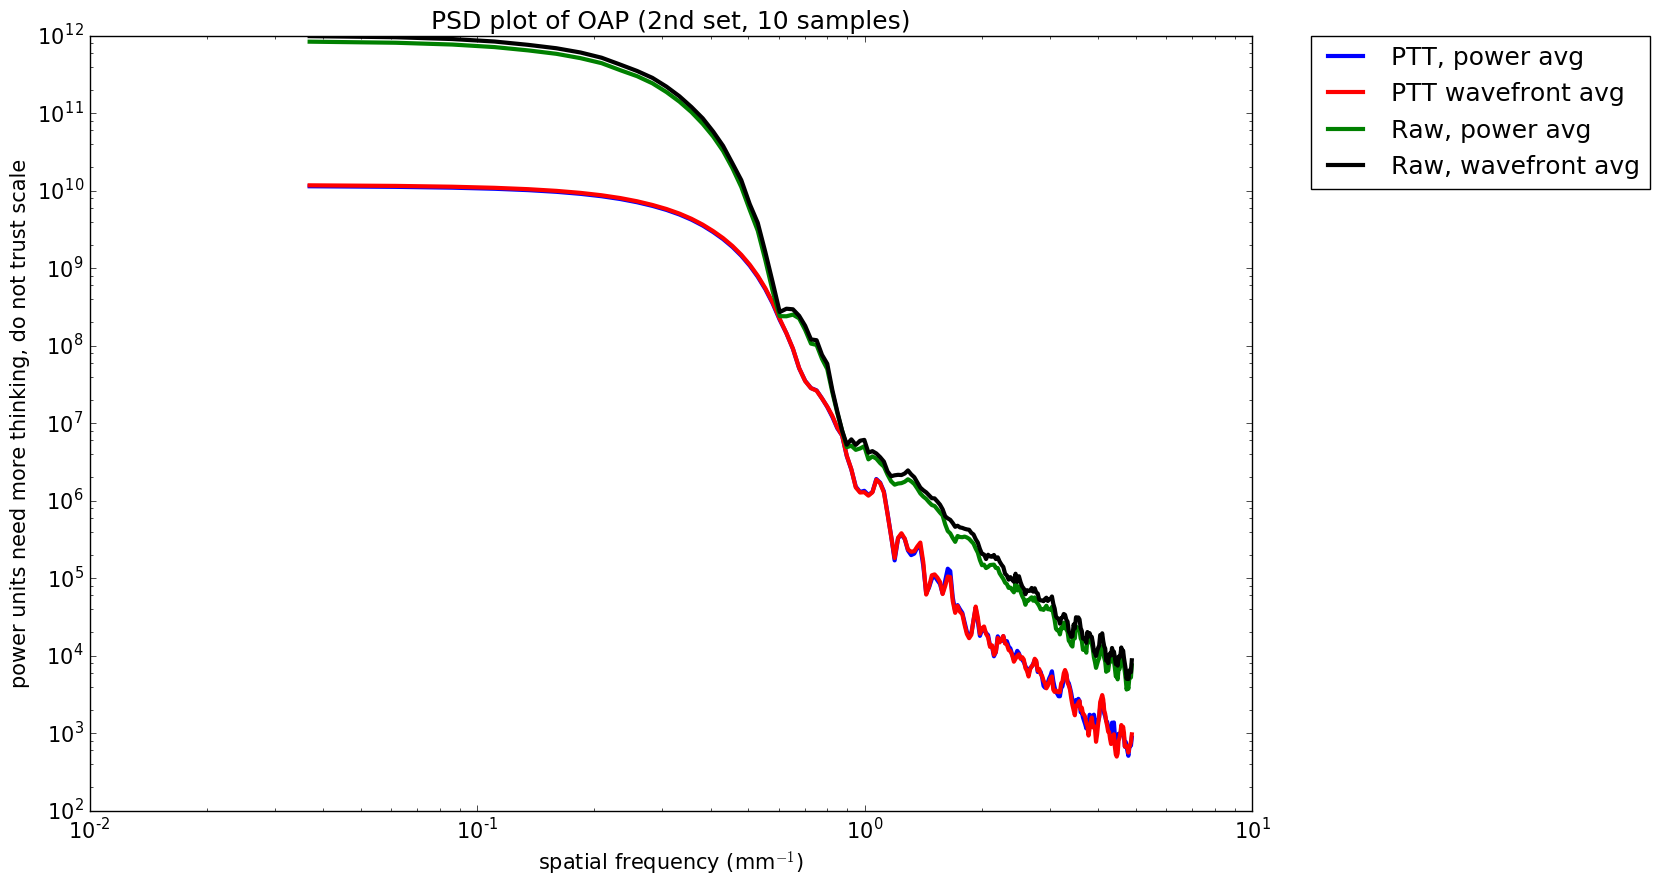

In [11]:
matplotlib.rcParams["font.size"]=15
plt.figure(figsize=[15,10])
plt.loglog(k_val, median_val, 'b',linewidth=3.0, label='PTT, power avg')
plt.loglog(k_val_avgWF, median_val_avgWF, 'r',linewidth=3.0, label='PTT wavefront avg')
plt.loglog(k_val_raw, median_val_raw, 'g',linewidth=3.0, label='Raw, power avg')
plt.loglog(k_val_raw_avgWF, median_val_raw_avgWF, 'k',linewidth=3.0, label='Raw, wavefront avg')
plt.title('PSD plot of OAP (2nd set, 10 samples)')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('power units need more thinking, do not trust scale')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)

## Averaged Wavefront (should be averaged after getting the power)

Import OAP averaged measurement. It's a FITS file for now, may change to hdf5 in the future.

In [7]:
optic_data, optic_header = fits.getdata('FITS/OAP4/PTT/OAP4_PTT_avg10.fits', header=True)
optic = psd.zeroPadSquare(optic_data)
hannWin = psd.makeHannWindow(np.shape(optic)[0])
optic_win = optic * hannWin
#plt.imshow(oap_win); plt.colorbar()
oversamp = 8
optic_wf = psd.zeroPadOversample(optic_win,oversamp)
zygo_wavelen = optic_header['WAVELEN']
shift = 200
power_optic = psd.doCenterCrop(psd.calcPower2(optic_wf),shift)
# Make the spatial frequency mapping
optic_aper_diam = (optic_header['CADIAM']/2)*(optic_header['MASKDIAM']/100)*1000 # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
radialFreq = freqMap[shift][shift:(2*shift)+1]
# Build the mask for the median radian power value
dr = 1 # assume 3 pixels forward to build the median
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]
r = 1 # skip the center pixel
median1_val = [] # initialize empty list of median power values
k1_val = [] # initialize empty list of frequencies
while((r+dr)<(shift)):
    radial_mask = psd.makeRingMask(maskY,maskX,r,dr)
    radial_bin = psd.makeRingMaskBin(power_optic, radial_mask)
    median1_val.append(np.median(radial_bin))
    k1_val.append(psd.getRadialSpatFreq(radialFreq,r,dr))
    r = r+1
#plt.loglog(k_val, median_val)
#plt.title('PSD plot of OAP4 (2nd set, 10 averaged, PTT removed)')
#plt.xlabel('spatial frequency (mm$^{-1}$)')
#plt.ylabel('power units need more thinking, do not trust scale') 

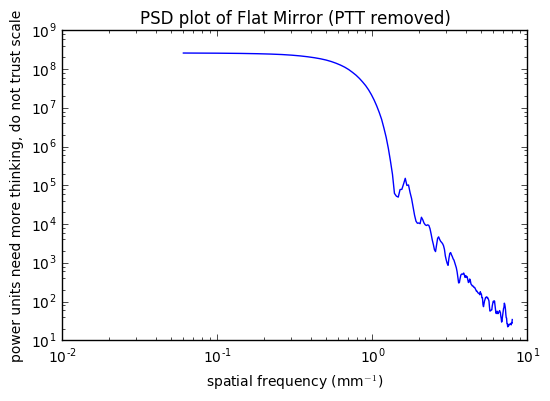

In [2]:
optic_data, optic_header = fits.getdata('FITS/FM/FM_PTT.fits', header=True)
optic = psd.zeroPadSquare(optic_data)
hannWin = psd.makeHannWindow(np.shape(optic)[0])
optic_win = optic * hannWin
#plt.imshow(oap_win); plt.colorbar()
oversamp = 8
optic_wf = psd.zeroPadOversample(optic_win,oversamp)
zygo_wavelen = optic_header['WAVELEN']
shift = 200
power_optic = psd.doCenterCrop(psd.calcPower2(optic_wf),shift)

# Make the spatial frequency mapping
optic_aper_diam = (optic_header['CADIAM']/2)*(optic_header['MASKDIAM']/100)*1000 # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
radialFreq = freqMap[shift][shift:(2*shift)+1]

# Build the mask for the median radian power value
dr = 1 # assume 3 pixels forward to build the median
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]
r = 1 # skip the center pixel
median_val = [] # initialize empty list of median power values
k_val = [] # initialize empty list of frequencies
while((r+dr)<(shift)):
    radial_mask = psd.makeRingMask(maskY,maskX,r,dr)
    radial_bin = psd.makeRingMaskBin(power_optic, radial_mask)
    median_val.append(np.median(radial_bin))
    k_val.append(psd.getRadialSpatFreq(radialFreq,r,dr))
    r = r+1
plt.loglog(k_val, median_val)
plt.title('PSD plot of Flat Mirror (PTT removed)')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('power units need more thinking, do not trust scale') 

In [3]:
np.shape(power_optic)

(400, 400)

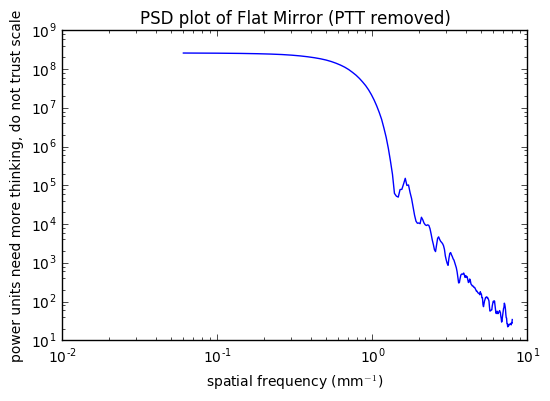

In [20]:
optic_data, optic_header = fits.getdata('FITS/FM/FM_PTT.fits', header=True)
optic = psd.zeroPadSquare(optic_data)
hannWin = psd.makeHannWindow(np.shape(optic)[0])
optic_win = optic * hannWin
#plt.imshow(oap_win); plt.colorbar()
oversamp = 8
optic_wf = psd.zeroPadOversample(optic_win,oversamp)
zygo_wavelen = optic_header['WAVELEN']
shift = 200
power_optic = psd.doCenterCrop(psd.calcPower2(optic_wf),shift)

# Make the spatial frequency mapping
optic_aper_diam = (optic_header['CADIAM']/2)*(optic_header['MASKDIAM']/100)*1000 # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
radialFreq = freqMap[shift][shift:(2*shift)+1]

# Build the mask for the median radian power value
dr = 1 # assume 3 pixels forward to build the median
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]
r = 1 # skip the center pixel
median_val = [] # initialize empty list of median power values
k_val = [] # initialize empty list of frequencies
while((r+dr)<(shift)):
    radial_mask = psd.makeRingMask(maskY,maskX,r,dr)
    radial_bin = psd.makeRingMaskBin(power_optic, radial_mask)
    median_val.append(np.median(radial_bin))
    k_val.append(psd.getRadialSpatFreq(radialFreq,r,dr))
    r = r+1
plt.loglog(k_val, median_val)
plt.title('PSD plot of Flat Mirror (PTT removed)')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('power units need more thinking, do not trust scale') 

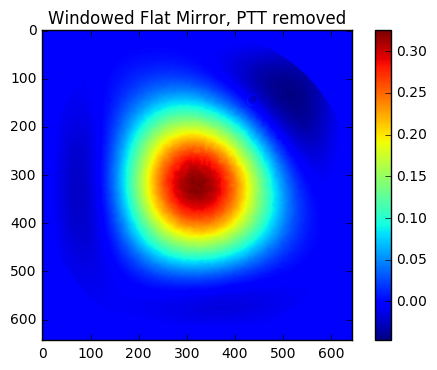

In [21]:
plt.imshow(optic_win); plt.colorbar(); plt.title('Windowed Flat Mirror, PTT removed')

Calculate PSD for averaged OAP4, PTT (version 2)

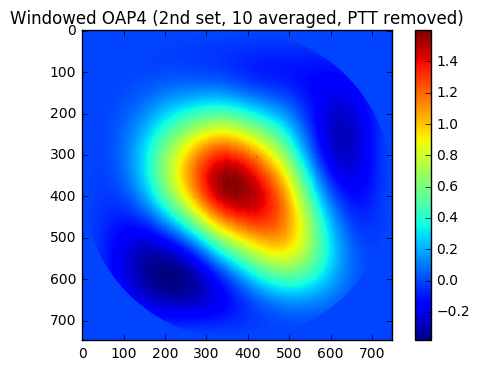

In [19]:
plt.imshow(optic_win); plt.colorbar(); plt.title('Windowed OAP4 (2nd set, 10 averaged, PTT removed)')

Calculate PSD for averaged OAP4, PTT (version 1, 5 average)

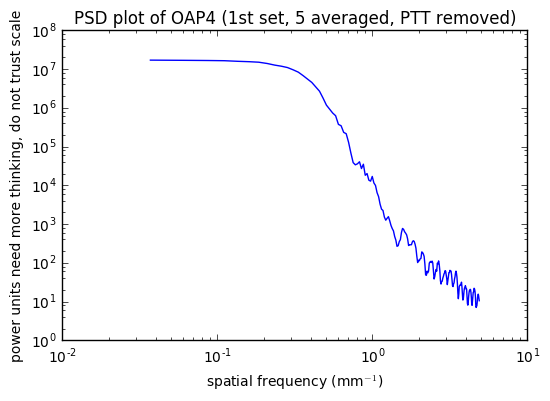

In [17]:
optic_data, optic_header = fits.getdata('FITS/OAP4/V1/OAP4_PTT_V1_avg5.fits', header=True)
optic = psd.zeroPadSquare(optic_data)
hannWin = psd.makeHannWindow(np.shape(optic)[0])
optic_win = optic * hannWin
#plt.imshow(oap_win); plt.colorbar()
oversamp = 8
optic_wf = psd.zeroPadOversample(optic_win,oversamp)
zygo_wavelen = optic_header['WAVELEN']
shift = 200
power_optic = psd.doCenterCrop(psd.calcPower2(optic_wf),shift)
# Make the spatial frequency mapping
optic_aper_diam = (optic_header['CADIAM']/2)*(optic_header['MASKDIAM']/100)*1000 # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
radialFreq = freqMap[shift][shift:(2*shift)+1]
# Build the mask for the median radian power value
dr = 1 # assume 3 pixels forward to build the median
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]
r = 1 # skip the center pixel
median_val = [] # initialize empty list of median power values
k_val = [] # initialize empty list of frequencies
while((r+dr)<(shift)):
    radial_mask = psd.makeRingMask(maskY,maskX,r,dr)
    radial_bin = psd.makeRingMaskBin(power_optic, radial_mask)
    median_val.append(np.median(radial_bin))
    k_val.append(psd.getRadialSpatFreq(radialFreq,r,dr))
    r = r+1
plt.loglog(k_val, median_val)
plt.title('PSD plot of OAP4 (1st set, 5 averaged, PTT removed)')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('power units need more thinking, do not trust scale') 

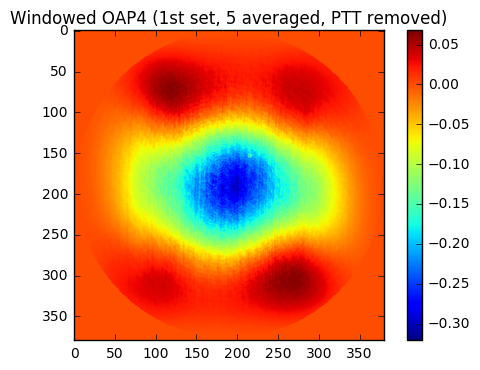

In [16]:
plt.imshow(optic_win); plt.colorbar(); plt.title('Windowed OAP4 (1st set, 5 averaged, PTT removed)')

In [31]:
optic_data, optic_header = fits.getdata('FITS/FM/FM_PTT.fits', header=True)
#oap_data, oap_header = fits.getdata('FITS/OAP4/V1/OAP4_PTT_V1_avg5.fits', header=True)
#oap_data, oap_header = fits.getdata('FITS/OAP4/PTT/OAP4_PTT_avg10.fits', header=True)
#oap_data, oap_header = fits.getdata('FITS/OAP4/OAP4_MASK_test5.fits', header=True)
#oap_data, oap_header = fits.getdata('Zygo_data/LAIRD_OAP_PTT.fits', header=True)

Zero pad the OAP data to get a better PSF

In [32]:
optic = psd.zeroPadSquare(optic_data)
hannWin = psd.makeHannWindow(np.shape(optic)[0])
optic_win = optic * hannWin
#plt.imshow(oap_win); plt.colorbar()
oversamp = 8
optic_wf = psd.zeroPadOversample(optic_win,oversamp)

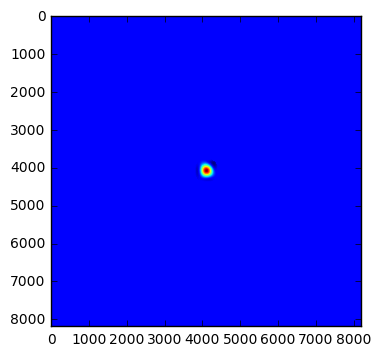

In [33]:
#plt.figure(figsize=[15,15])
plt.imshow(optic_wf)

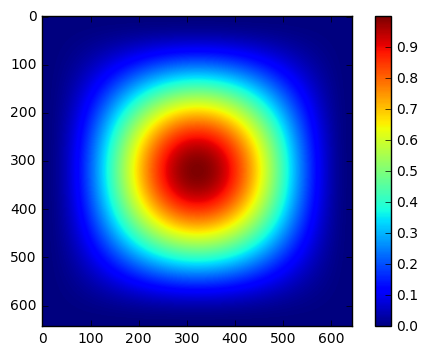

In [34]:
plt.imshow(hannWin)
plt.colorbar()

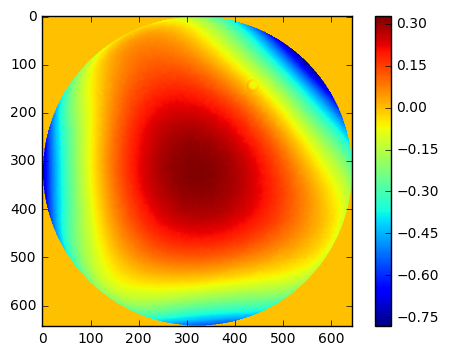

In [35]:
plt.imshow(optic)
plt.colorbar()

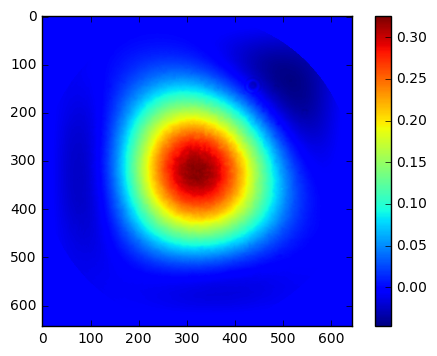

In [36]:
plt.imshow(optic_win)
plt.colorbar()

Get power distribution of the wavefront

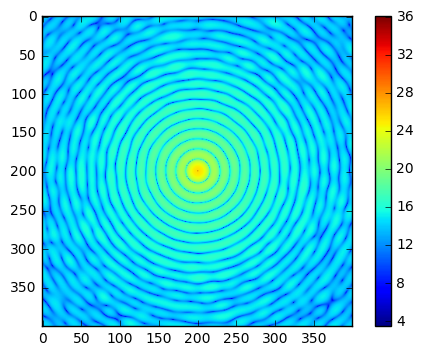

In [42]:
zygo_wavelen = optic_header['WAVELEN']
shift = 200
power_optic = psd.doCenterCrop(psd.calcPower(optic_wf,zygo_wavelen),shift)
plt.imshow(np.log(np.real(power_optic)))
plt.colorbar()

Build the frequency space map

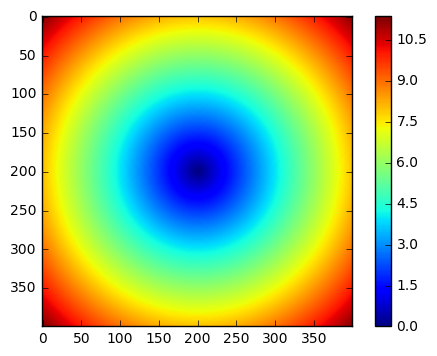

In [43]:
optic_aper_diam = (optic_header['CADIAM']/2)*(optic_header['MASKDIAM']/100)*1000 # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
plt.imshow(freqMap)
plt.colorbar()

The frequency values are the same radially, so only need to get a single radial vector.

In [44]:
radialFreq = freqMap[shift][shift:(2*shift)+1]
np.shape(radialFreq)

(200,)

Calculate the power value of median radial frequency distance.

In [45]:
dr = 1 # assume 3 pixels forward to build the median
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]
r = 1 # skip the center pixel
median_val = [] # initialize empty list of median power values
k_val = [] # initialize empty list of frequencies
while((r+dr)<(shift)):
    radial_mask = psd.makeRingMask(maskY,maskX,r,dr)
    radial_bin = psd.makeRingMaskBin(power_optic, radial_mask)
    median_val.append(np.median(radial_bin))
    k_val.append(psd.getRadialSpatFreq(radialFreq,r,dr))
    r = r+1

Plot the power value against the pixel value (which can be converted to frequency space value by overlaying the k-map frequency space map) to build the PSD.

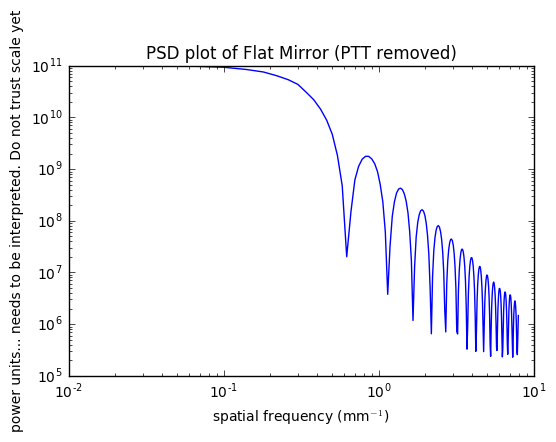

In [47]:
plt.loglog(k_val, median_val)
plt.title('PSD plot of Flat Mirror (PTT removed)')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('power units... needs to be interpreted. Do not trust scale yet')

Try with RAW FM

In [8]:
raw_data, raw_header = fits.getdata('FITS/FM/FM_RAW.fits', header=True)
optic_raw = psd.zeroPadSquare(raw_data)
hannWin_raw = psd.makeHannWindow(np.shape(optic_raw)[0])
optic_raw_win = optic_raw * hannWin_raw
#plt.imshow(oap_win); plt.colorbar()
oversamp = 8
optic_raw_wf = psd.zeroPadOversample(optic_raw_win,oversamp)

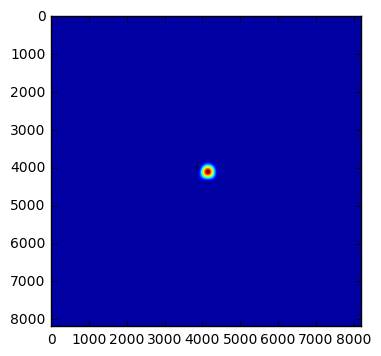

In [9]:
#plt.figure(figsize=[15,15])
plt.imshow(optic_raw_wf)

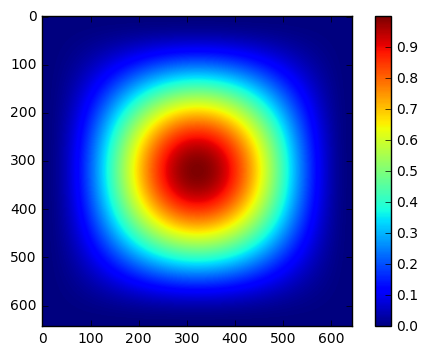

In [10]:
plt.imshow(hannWin_raw)
plt.colorbar()

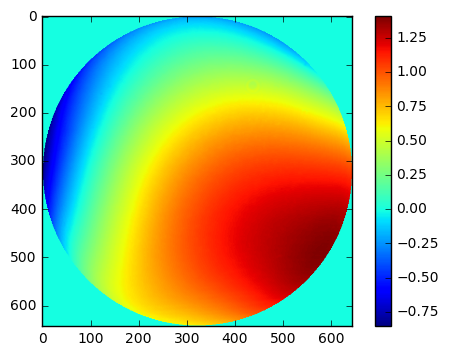

In [11]:
plt.imshow(optic_raw)
plt.colorbar()

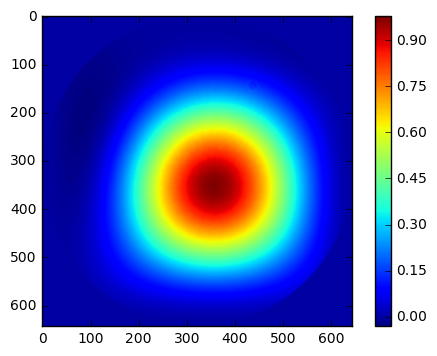

In [12]:
plt.imshow(optic_raw_win)
plt.colorbar()

Get power distribution of the wavefront

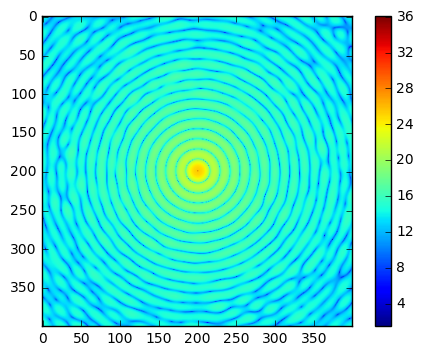

In [13]:
zygo_wavelen = raw_header['WAVELEN']
shift = 200
power_raw_optic = psd.doCenterCrop(psd.calcPower(optic_raw_wf,zygo_wavelen),shift)
plt.imshow(np.log(np.real(power_raw_optic)))
plt.colorbar()

Build the frequency space map

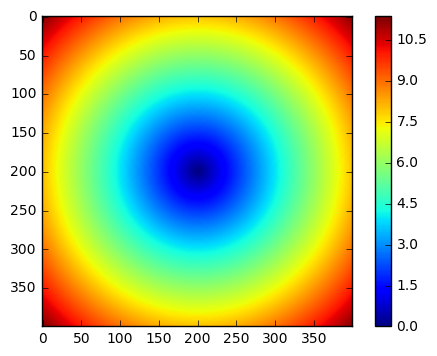

In [14]:
optic_aper_diam = (raw_header['CADIAM']/2)*(raw_header['MASKDIAM']/100)*1000 # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
plt.imshow(freqMap)
plt.colorbar()


The frequency values are the same radially, so only need to get a single radial vector.

In [15]:
radialFreq = freqMap[shift][shift:(2*shift)+1]
np.shape(radialFreq)

(200,)

Calculate the power value of median radial frequency distance.

In [16]:
dr = 1 # assume 3 pixels forward to build the median
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]
r = 1 # skip the center pixel
median_val_raw = [] # initialize empty list of median power values
k_val_raw = [] # initialize empty list of frequencies
while((r+dr)<(shift)):
    radial_mask = psd.makeRingMask(maskY,maskX,r,dr)
    radial_bin = psd.makeRingMaskBin(power_raw_optic, radial_mask)
    median_val_raw.append(np.median(radial_bin))
    k_val_raw.append(psd.getRadialSpatFreq(radialFreq,r,dr))
    r = r+1

Plot the power value against the pixel value (which can be converted to frequency space value by overlaying the k-map frequency space map) to build the PSD.

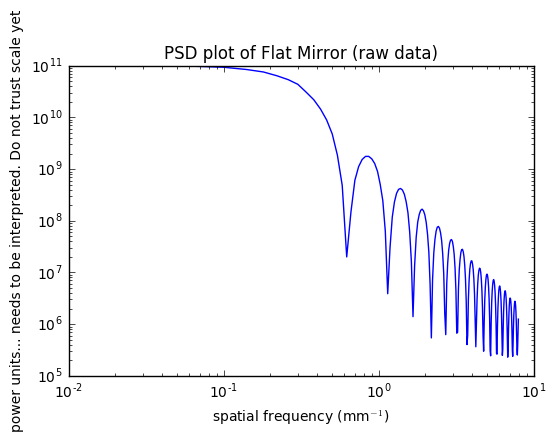

In [17]:
plt.loglog(k_val_raw, median_val_raw)
plt.title('PSD plot of Flat Mirror (raw data)')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('power units... needs to be interpreted. Do not trust scale yet')

Try with no exponential

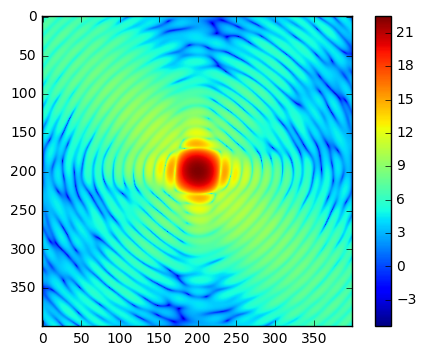

In [2]:
raw_data, raw_header = fits.getdata('FITS/FM/FM_RAW.fits', header=True)
optic_raw = psd.zeroPadSquare(raw_data)
hannWin_raw = psd.makeHannWindow(np.shape(optic_raw)[0])
optic_raw_win = optic_raw * hannWin_raw
#plt.imshow(oap_win); plt.colorbar()
oversamp = 8
optic_raw_wf = psd.zeroPadOversample(optic_raw_win,oversamp)
zygo_wavelen = raw_header['WAVELEN']
shift = 200
power_raw_optic = psd.doCenterCrop(psd.calcPower2(optic_raw_wf),shift)
plt.imshow(np.log(np.real(power_raw_optic)))
plt.colorbar()

Build the frequency space map

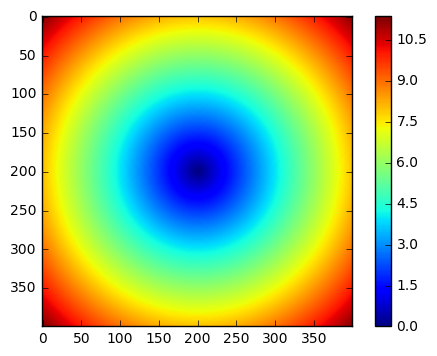

In [3]:
optic_aper_diam = (raw_header['CADIAM']/2)*(raw_header['MASKDIAM']/100)*1000 # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
plt.imshow(freqMap)
plt.colorbar()

The frequency values are the same radially, so only need to get a single radial vector.

In [4]:
radialFreq = freqMap[shift][shift:(2*shift)+1]
np.shape(radialFreq)

(200,)

Calculate the power value of median radial frequency distance.

In [6]:
dr = 1 # assume 3 pixels forward to build the median
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]
r = 1 # skip the center pixel
median_val_raw = [] # initialize empty list of median power values
k_val_raw = [] # initialize empty list of frequencies
while((r+dr)<(shift)):
    radial_mask = psd.makeRingMask(maskY,maskX,r,dr)
    radial_bin = psd.makeRingMaskBin(power_raw_optic, radial_mask)
    median_val_raw.append(np.median(radial_bin))
    k_val_raw.append(psd.getRadialSpatFreq(radialFreq,r,dr))
    r = r+1

Plot the power value against the pixel value (which can be converted to frequency space value by overlaying the k-map frequency space map) to build the PSD.

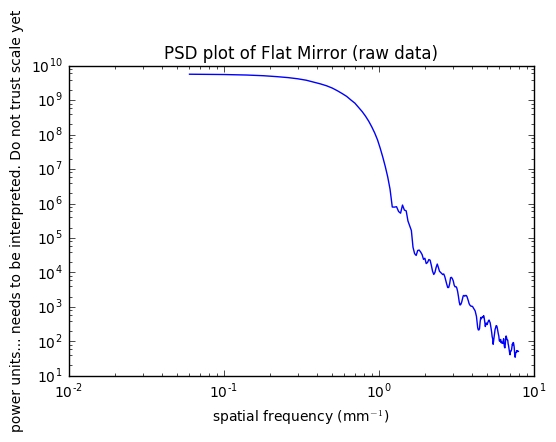

In [7]:
plt.loglog(k_val_raw, median_val_raw)
plt.title('PSD plot of Flat Mirror (raw data)')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('power units... needs to be interpreted. Do not trust scale yet')

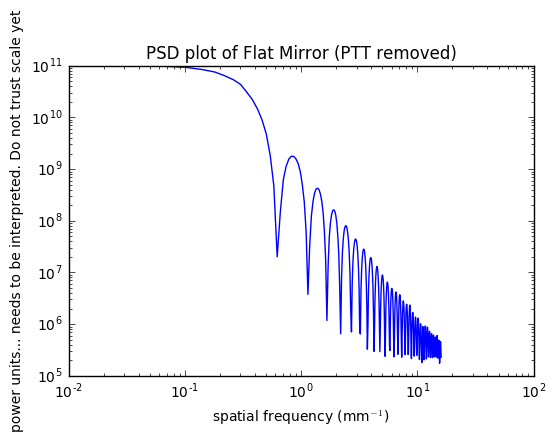

In [41]:
plt.loglog(k_val, median_val)
plt.title('PSD plot of Flat Mirror (PTT removed)')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('power units... needs to be interpreted. Do not trust scale yet')

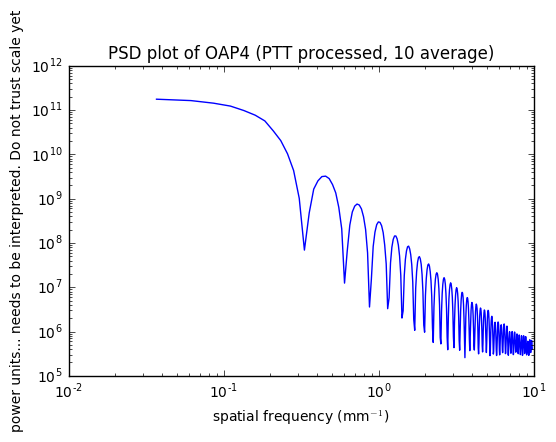

In [50]:
plt.loglog(k_val, median_val)
plt.title('PSD plot of OAP4 (PTT processed, 10 average)')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('power units... needs to be interpreted. Do not trust scale yet')

## Things to do:
- Need to interpret the vertical axis units!
- Need to understand the zygo wavefront units.

# Code Development Junk Pile
Where modules are developed and tested. Once code does the job, it is cleaned up and inserted into the PSD_defns.py file. The test run here then gets deleted.

## Center Pixel Masking
The center pixel is killing the whole thing, so let's mask it out.

/home/jhen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


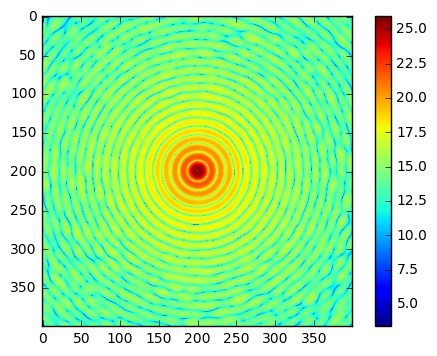

In [7]:
center_mask = np.ones((2*shift,2*shift))
center_mask[shift][shift] = 0
mask_crop_power_oap = np.multiply(crop_power_oap,center_mask)
plt.imshow(np.log(np.real(mask_crop_power_oap)))
plt.colorbar()